# Buyer's Time Prediction Challenge (MachineHack)

#### Overview

Buyers spend a significant amount of time surfing an e-commerce store, since the pandemic the e-commerce has seen a boom in the number of users across the domains. In the meantime, the store owners are also planning to attract customers using various algorithms to leverage customer behavior patterns

Tracking customer activity is also a great way of understanding customer behavior and figuring out what can actually be done to serve them better. Machine learning and AI has already played a significant role in designing various recommendation engines to lure customers by predicting their buying patterns

In this competition provided the visitor's session data, we are challenging the Machinehack community to come up with a regression algorithm to predict the time a buyer will spend on the platform.

#### Attribute Description:

* session_id - Unique identifier for every row
* session_number - Session type identifier
* client_agent - Client-side software details
* device_details -  Client-side device details
* date - Datestamp of the session
* purchased - Binary value for any purchase done
* added_in_cart - Binary value for cart activity
* checked_out -  Binary value for checking out successfully
* time_spent - Total time spent in seconds (Target Column)

 
#### Skills:

* Regression Modeling
* Advance Feature engineering, with Datestamp and Text datatypes
* Optimizing RMSLE score as a metric to generalize well on unseen data

###### python libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

###### data visualization libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization and Feature Engineering

In [3]:
train = pd.read_csv('Data/Train.csv')
test = pd.read_csv('Data/Test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_id      5429 non-null   object 
 1   session_number  5429 non-null   int64  
 2   client_agent    5269 non-null   object 
 3   device_details  5429 non-null   object 
 4   date            5429 non-null   object 
 5   purchased       5429 non-null   int64  
 6   added_in_cart   5429 non-null   int64  
 7   checked_out     5429 non-null   int64  
 8   time_spent      5429 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 381.9+ KB


### We will convert the time_spent (seconds) into mins. During prediction we will multiply our predicted values with 60 to convert to seconds.

In [5]:
train['time_spent'] = train['time_spent']/60

###### Changing datatype of date column

In [6]:
train['date'] = train['date'].astype('datetime64')
test['date'] = test['date'].astype('datetime64')

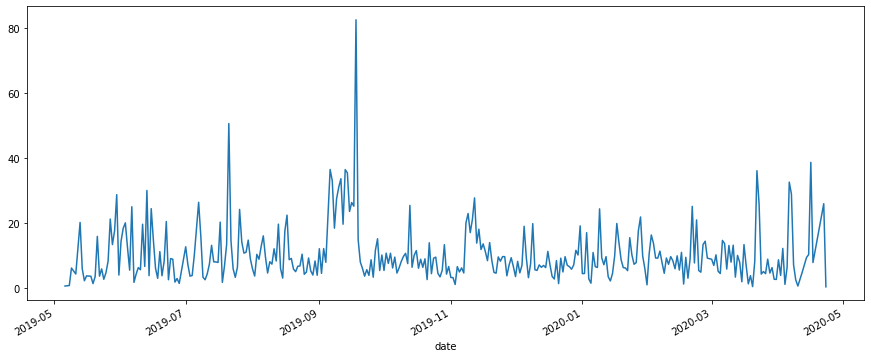

In [7]:
plt.figure(figsize = (15,6))
train.groupby('date')['time_spent'].mean().plot()
plt.show()

# There are outliers between 2019-09 and 2019-11 that has spent close to 5000 units

###### Let us convert the date column into seperate columns

In [8]:
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['dayofweek'] = train['date'].dt.dayofweek
train['year'] = train['date'].dt.year
train['weekofyear'] = train['date'].dt.week
train['dayofyear'] = ((train['weekofyear']*7)-7)+train['dayofweek']

In [9]:
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['dayofweek'] = test['date'].dt.dayofweek
test['year'] = test['date'].dt.year
test['weekofyear'] = test['date'].dt.weekofyear
test['dayofyear'] = ((test['weekofyear']*7)-7)+test['dayofweek']

In [10]:
# Change the months to start from May instead of Jan to get full year
#train['month'] = [train['month'][i]-4 if train['year'][i]==2019 else train['month'][i]+8 for i in range(len(train['date']))]

# Now let us look at the trend of time_spent across a year

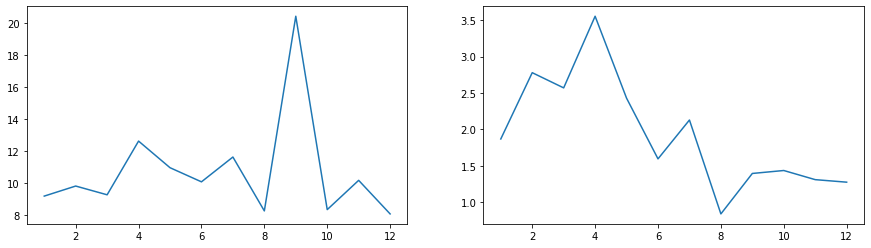

In [11]:
fig,ax = plt.subplots(1,2,figsize = (15,4))
mn = train.groupby('month')['time_spent'].mean()
mdn = train.groupby('month')['time_spent'].median()
ax[0].plot(mn)
ax[1].plot(mdn)
plt.show()

##### Month 9 seems to exhibit some odd characteristic. It is too high compared to the rest of the data. We will handle outliers in this particular month first and regraph the trend of time_spent by mean and median

Text(0, 0.5, 'time spent in hrs')

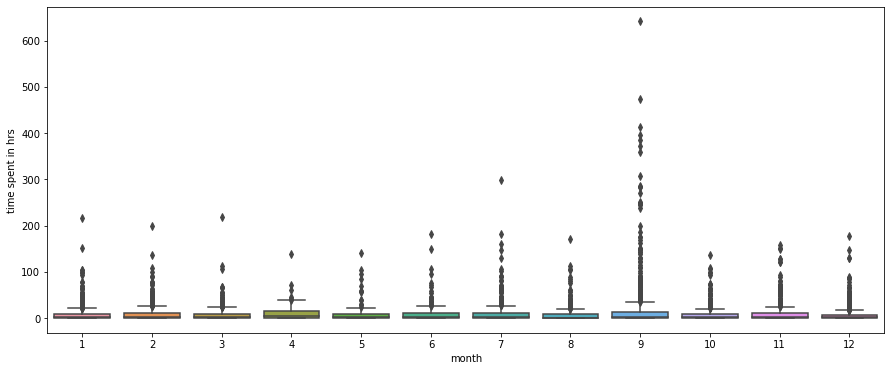

In [12]:
plt.figure(figsize = (15,6))
sns.boxplot('month','time_spent',data = train)
plt.ylabel('time spent in hrs')

###### 600 hrs for a session on an ecommerce website! I don't think so..

In [13]:
train[train['month']==9]['time_spent'].describe([0.75,.85,.95])

count    828.000000
mean      20.410919
std       56.280119
min        0.240000
50%        1.393550
75%       14.178921
85%       30.509122
95%       92.087670
max      641.567083
Name: time_spent, dtype: float64

In [14]:
def outlier_param(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3-Q1
    return Q3+(1.5*IQR)

###### If I were to remove outliers based on the 9th month we would lose 1082 records.

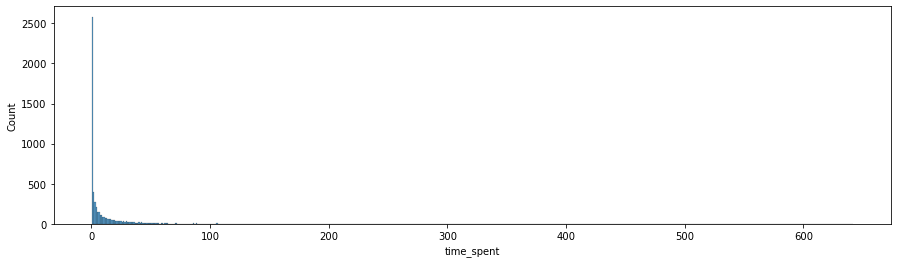

In [15]:
plt.figure(figsize = (15,4))
sns.histplot(train['time_spent'])

In [16]:
o = outlier_param(train['time_spent'])
o

24.451816666666677

In [17]:
train = train[train['time_spent']<=o]

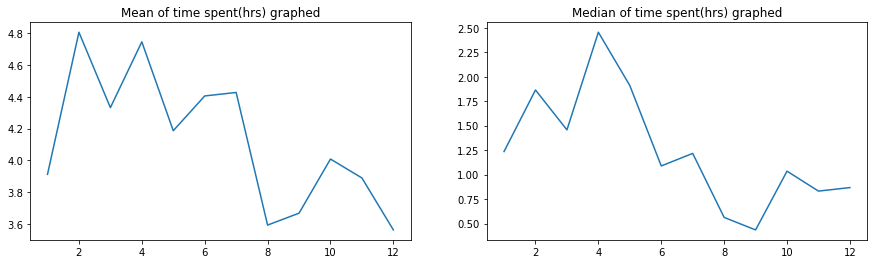

In [18]:
fig,ax = plt.subplots(1,2,figsize = (15,4))
mn = train.groupby('month')['time_spent'].mean()
mdn = train.groupby('month')['time_spent'].median()
ax[0].plot(mn)
ax[0].set_title('Mean of time spent(hrs) graphed')
ax[1].plot(mdn)
ax[1].set_title('Median of time spent(hrs) graphed')
plt.show()

###### Compared to before our mean and median graphs look more similar or follow a similar trend.

###### 1 day consists of 24 hrs. I really feel it is not in human nature to spend an entire day on an ecommerce website!

###### Let us look at the month vs time_spent boxplot again

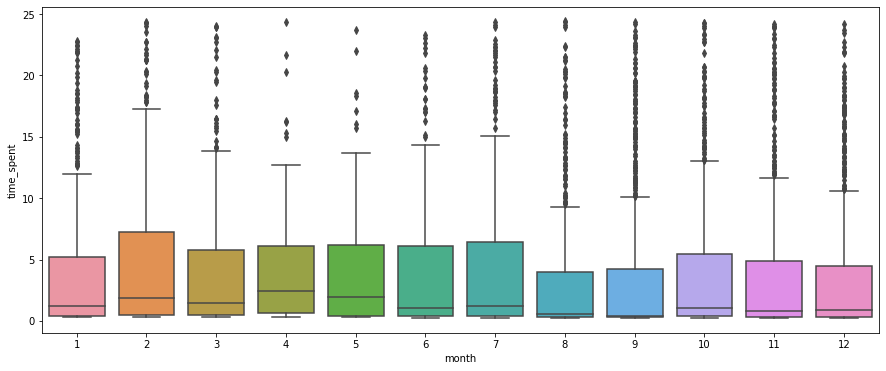

In [19]:
plt.figure(figsize = (15,6))
sns.boxplot('month','time_spent',data = train)

###### Since the data is day wise I assume that a session does not go over a day or should not go over a day. If it is going over a day it means that the logging system is faulty. It could be possible that a person left the website on at his end but most probably our backend system is considering a customer to stayed logged in while in reality he is not.

###### For the rest of the outliers in the data set we will apply a log transformation to the time_spent column  to further remove any outliers. 

In [20]:
# train['time_spent'] = np.log(train['time_spent'])

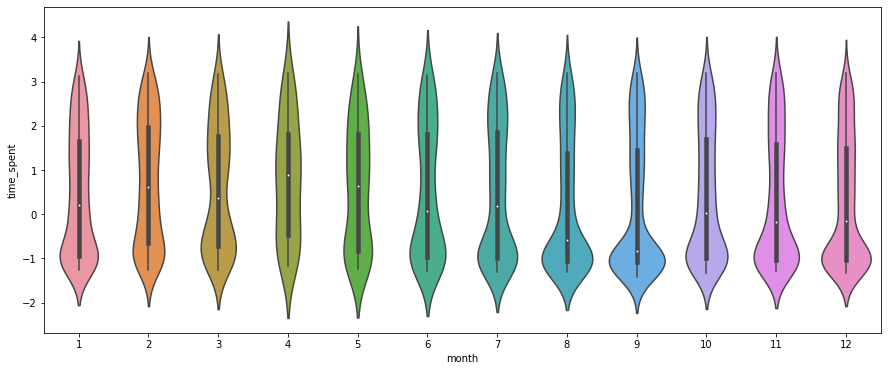

In [21]:
plt.figure(figsize = (15,6))
sns.violinplot('month',np.log(train['time_spent']),data = train)
plt.show()

###### As we can see now, we do not have any outliers and data for all months will be normally distributed due to the log transformation.

###### Creating seperate columns for device and platform

In [22]:
def new_cols(column,val):
    return [i.split('-')[val].strip() for i in column]

In [23]:
train['device'] = new_cols(train['device_details'],0)
test['device'] = new_cols(test['device_details'],0)

train['platform'] = new_cols(train['device_details'],1)
test['platform'] = new_cols(test['device_details'],1)

###### Dropping unnecessary columns

In [24]:
train.drop(['session_id','session_number','client_agent','date'],axis = 1,inplace = True)
test.drop(['session_id','session_number','client_agent','date'],axis = 1,inplace = True)

In [25]:
train

,device_details,purchased,added_in_cart,checked_out,time_spent,day,month,dayofweek,year,weekofyear,dayofyear,device,platform
0,Desktop - Chrome,1,0,0,3.948100,22,1,2,2020,4,23,Desktop,Chrome
1,iPhone - iOS,1,0,0,21.290917,27,2,3,2020,9,59,iPhone,iOS
2,iPhone - MobileWeb,0,0,0,0.361733,1,8,3,2019,31,213,iPhone,MobileWeb
3,Desktop - IE,0,1,0,7.586683,30,12,0,2019,1,0,Desktop,IE
4,iPhone - Web,0,0,0,19.414617,10,9,1,2019,37,253,iPhone,Web
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,Android Tablet - Web,1,0,0,8.758600,28,2,4,2020,9,60,Android Tablet,Web
5424,iPhone - Web,0,0,0,0.343350,20,11,2,2019,47,324,iPhone,Web
5426,Desktop - Chrome,0,0,0,0.378517,13,8,1,2019,33,225,Desktop,Chrome
5427,Unknown - MobileWeb,0,0,0,0.347400,18,6,1,2019,25,169,Unknown,MobileWeb


###### Let us look at the relation between time spent and purchased,added_in_cart and checked_out using facetgrid

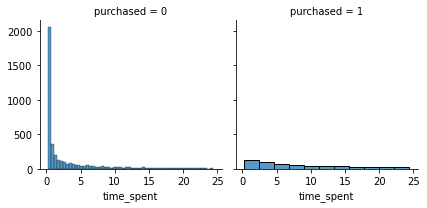

In [26]:
gg = sns.FacetGrid(train,col = 'purchased')
gg.map(sns.histplot,'time_spent')
plt.show()

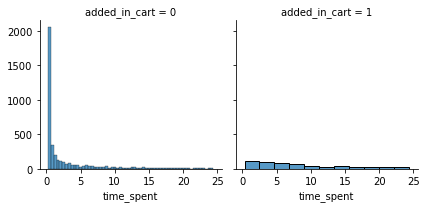

In [27]:
gg = sns.FacetGrid(train,col = 'added_in_cart')
gg.map(sns.histplot,'time_spent')
plt.show()

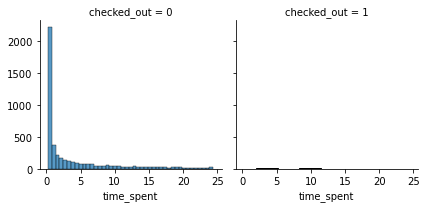

In [28]:
gg = sns.FacetGrid(train,col = 'checked_out')
gg.map(sns.histplot,'time_spent')
plt.show()

###### From the above FacetGrids it still isnt clear whether purchasing or inshort activity on the site translates to more time being spent on the site

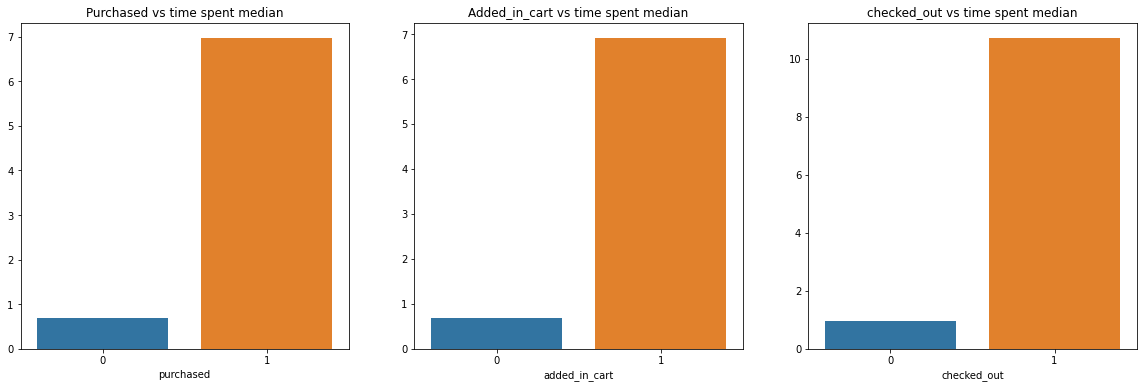

In [29]:
med_p = train.groupby('purchased')['time_spent'].median()
med_aic = train.groupby('added_in_cart')['time_spent'].median()
med_co = train.groupby('checked_out')['time_spent'].median()

fig,ax = plt.subplots(1,3,figsize = (20,6))
sns.barplot(med_p.index,med_p.values,ax = ax[0])
ax[0].set_title("Purchased vs time spent median")
sns.barplot(med_aic.index,med_aic.values,ax = ax[1])
ax[1].set_title("Added_in_cart vs time spent median")
sns.barplot(med_co.index,med_co.values,ax = ax[2])
ax[2].set_title("checked_out vs time spent median")
plt.show()

###### These graphs give us a better idea. Time_spent is related to the 3 categorical columns that were given in the original dataset. 

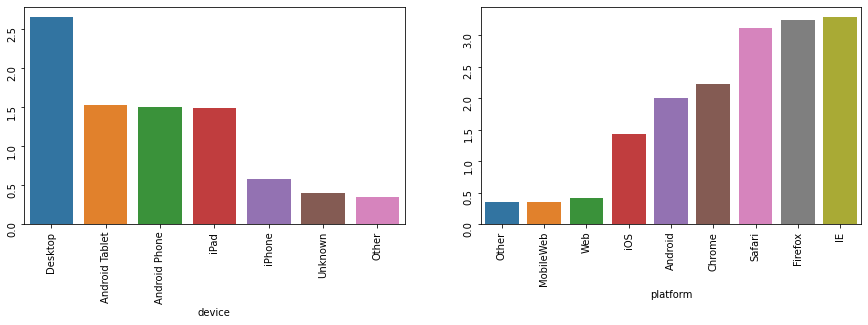

In [30]:
med_d = train.groupby('device')['time_spent'].median().sort_values(ascending = False)
med_pl = train.groupby('platform')['time_spent'].median().sort_values()
fig,ax = plt.subplots(1,2,figsize = (15,4))
sns.barplot(med_d.index,med_d.values,ax = ax[0])
ax[0].tick_params(rotation = 90)
sns.barplot(med_pl.index,med_pl.values,ax = ax[1])
ax[1].tick_params(rotation = 90)
plt.show()

###### Consumers who use their computer seem to spend the most amount of time on the site. A similar trend with browsers. Surprising to see Internet Explorer users spending more time on the site than other browser users. Maybe the data is old.

###### Dropping device_details column

In [31]:
train.drop('device_details',axis = 1,inplace = True)
test.drop('device_details',axis = 1,inplace = True)

In [32]:
train.shape,test.shape

((4759, 12), (2327, 11))

In [33]:
train.columns,test.columns

(Index(['purchased', 'added_in_cart', 'checked_out', 'time_spent', 'day',
        'month', 'dayofweek', 'year', 'weekofyear', 'dayofyear', 'device',
        'platform'],
       dtype='object'),
 Index(['purchased', 'added_in_cart', 'checked_out', 'day', 'month',
        'dayofweek', 'year', 'weekofyear', 'dayofyear', 'device', 'platform'],
       dtype='object'))

###### Applying Anova to check which variables seems to have an impact on the dependent variable based on p-value

In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import stats

$H_O$: Given categorical variables have no effect on the dependent variable.

$H_A$: Given categorical variables have a significant effect on the dependent variable.

In [35]:
model = ols("time_spent~purchased+added_in_cart+checked_out+checked_out:purchased+checked_out:added_in_cart+purchased:added_in_cart+checked_out:purchased:added_in_cart",data = train).fit()
cat = pd.DataFrame(sm.stats.anova_lm(model))
cat

,df,sum_sq,mean_sq,F,PR(>F)
purchased,1.0,15040.633090,15040.633090,591.228808,3.458229e-123
added_in_cart,1.0,16277.148553,16277.148553,639.834712,1.512225e-132
checked_out,1.0,355.847949,355.847949,13.987946,1.861541e-04
checked_out:purchased,1.0,46.688724,46.688724,1.835276,1.755700e-01
checked_out:added_in_cart,1.0,103.031292,103.031292,4.050034,4.422679e-02
purchased:added_in_cart,1.0,83.012591,83.012591,3.263123,7.091732e-02
checked_out:purchased:added_in_cart,1.0,2.560798,2.560798,0.100662,7.510508e-01
Residual,4751.0,120863.609594,25.439615,NaN,NaN


In [36]:
cat[cat.loc[:,'PR(>F)']<0.05]

,df,sum_sq,mean_sq,F,PR(>F)
purchased,1.0,15040.633090,15040.633090,591.228808,3.458229e-123
added_in_cart,1.0,16277.148553,16277.148553,639.834712,1.512225e-132
checked_out,1.0,355.847949,355.847949,13.987946,1.861541e-04
checked_out:added_in_cart,1.0,103.031292,103.031292,4.050034,4.422679e-02


In [37]:
train['checked_out+added_in_cart'] = train['checked_out']+train['added_in_cart']
test['checked_out+added_in_cart'] = test['checked_out']+test['added_in_cart']

#### Since all values are less than 0.05 we can reject the null hypothesis. The 3 variables have a significant effect on the categorical variable. While checked_out+added_in_cart also seems to have an impact on the dependent variable together. The other combinations seem to not create significant impact.

###### Let us check with date related columns and their impact on the independent variable.

In [38]:
model = ols("time_spent~day+month+dayofweek+year+weekofyear+dayofyear+month:day+month:year+month:dayofweek+month:weekofyear+month:dayofyear",data = train).fit()
cat = pd.DataFrame(sm.stats.anova_lm(model))
cat

,df,sum_sq,mean_sq,F,PR(>F)
day,1.0,62.504702,62.504702,1.949653,0.162689
month,1.0,300.485938,300.485938,9.372790,0.002215
dayofweek,1.0,22.871281,22.871281,0.713403,0.398359
year,1.0,0.856033,0.856033,0.026701,0.870206
weekofyear,1.0,0.114580,0.114580,0.003574,0.952331
dayofyear,1.0,4.779279,4.779279,0.149076,0.699437
month:day,1.0,0.060325,0.060325,0.001882,0.965402
month:year,1.0,102.426596,102.426596,3.194901,0.073932
month:dayofweek,1.0,26.374713,26.374713,0.822683,0.364443
month:weekofyear,1.0,7.399221,7.399221,0.230797,0.630955


In [39]:
cat[cat.loc[:,'PR(>F)']<0.05]

,df,sum_sq,mean_sq,F,PR(>F)
month,1.0,300.485938,300.485938,9.37279,0.002215


###### Month seems to be the only column that has any impact on the dependent variable. We will drop the rest of the imputations.

In [40]:
train.drop(['day','month','year','dayofweek','weekofyear','dayofyear'],axis = 1,inplace = True)
test.drop(['day','month','year','dayofweek','weekofyear','dayofyear'],axis = 1,inplace = True)

### Perform One hot encoding on Device and platform variables since they are nominal and not ordinal. Label Encoding is not suitable because it would introduce magnitude into the column making it difficult for the model to generalize over the dataset.

In [41]:
device_dummies_train = pd.get_dummies(train['device'])
device_dummies_test = pd.get_dummies(test['device'])

platform_dummies_train = pd.get_dummies(train['platform'])
platform_dummies_test = pd.get_dummies(test['platform'])

device_dummies_train = device_dummies_train.drop('Unknown',axis = 1)
device_dummies_test = device_dummies_test.drop('Unknown',axis = 1)

platform_dummies_train = platform_dummies_train.drop('Other',axis = 1)
platform_dummies_test = platform_dummies_test.drop('Other',axis = 1)

train = train.drop(['device','platform'],axis = 1)
test = test.drop(['device','platform'],axis = 1)

train = pd.concat((train,device_dummies_train,platform_dummies_train),axis = 1)
test = pd.concat((test,device_dummies_test,platform_dummies_test),axis = 1)

train.shape,test.shape

((4759, 19), (2327, 18))

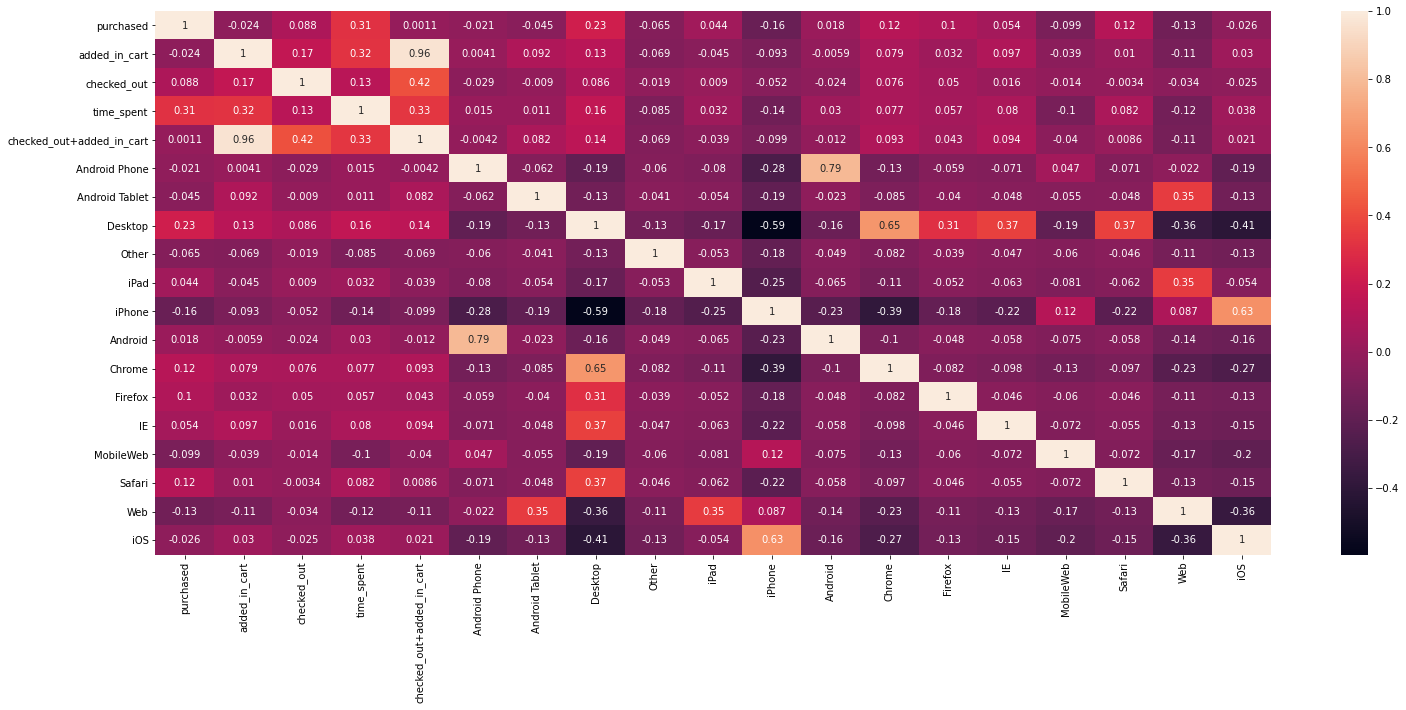

In [42]:
plt.figure(figsize = (25,10))
sns.heatmap(train.corr(),annot = True)
plt.show()

###### We should also look at the variance inflation factor to see the influence of the left over variables on other independent variables in the dataset

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = train.drop('time_spent',axis= 1)
vif_data = pd.DataFrame()
vif_data['Columns'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

C:\Users\tejas\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [51]:
vif_data

,Columns,VIF
0,purchased,1.095012e+00
1,added_in_cart,5.429094e+07
2,checked_out,inf
3,checked_out+added_in_cart,inf
4,Android Phone,7.537944e+00
5,Android Tablet,3.940156e+00
6,Desktop,inf
7,Other,1.000163e+00
8,iPad,5.551995e+00
9,iPhone,1.775339e+01


# ML Modelling

###### ML Libraries

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_log_error,make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor